In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textlog import textSetup
text = textSetup(prefix='Depreciation: ')
from warnings import warn
from matplotlib.ticker import FuncFormatter

def weighted_percentile (vals, percentiles, weights):
    if len(vals) != len(weights):
        raise ArgumentError('values and weights arrays are not same length!')

    nas = pd.isnull(vals) | pd.isnull(weights)

    nnas = np.sum(nas)
    if nnas > 0:
        warn(f'found {nnas} NAs in data, dropping them')

    vals = vals[~nas]
    weights = weights[~nas]

    weights = weights / np.sum(weights)
    sortIdx = np.argsort(vals)
    vals = vals.iloc[sortIdx]
    weights = weights.iloc[sortIdx]

    cumWeights = np.cumsum(weights)
    if not isinstance(percentiles, np.ndarray):
        percentiles = np.array(percentiles)
    percentiles = percentiles / 100

    # center weights, i.e. put the point value halfway through the weight
    # https://github.com/nudomarinero/wquantiles/blob/master/wquantiles.py
    centeredCumWeights = cumWeights - 0.5 * weights
    return np.interp(percentiles, centeredCumWeights, vals)


In [2]:
data = pd.read_stata('../data/final_data.dta')
data = data[(data.BESTMILE >= 100) & ~pd.isnull(data.fuelCost)].copy()

In [3]:
vehiclesPreDrop = pd.read_csv('../data/vehicles_fuel_economy_value.csv')

In [4]:
households = pd.read_csv('../data/nhts/hhpub.csv').set_index('HOUSEID')

In [5]:
data['totalCost'] = data.insuranceCostDiscounted + data.maintenanceTireCost + data.annualDepreciation + data.regfee + data.fuelCost
data['marginalCostPerMile'] = (data.maintenanceTireCost + data.fuelCost) / data.BESTMILE
data['averageCostPerMile'] = data.totalCost / data.BESTMILE

In [6]:
assert not np.any(data.annualDepreciation < 0)

In [7]:
assert not np.any(pd.isnull(data.totalCost))

In [8]:
data[pd.isnull(data.regfee)].HHSTATE.unique()

array([], dtype=object)

In [50]:
# Save histograms to csv for summarized output
def histToCsv (data, outputFile, *args, **kwargs):
    hist = np.histogram(data, *args, **kwargs)
    df = pd.DataFrame({
        'binLeft': hist[1][:-1],
        'binRight': hist[1][1:],
        'value': hist[0]
    })
    df.to_csv(outputFile, index=False)

Text(0,0.5,'Number of vehicles')

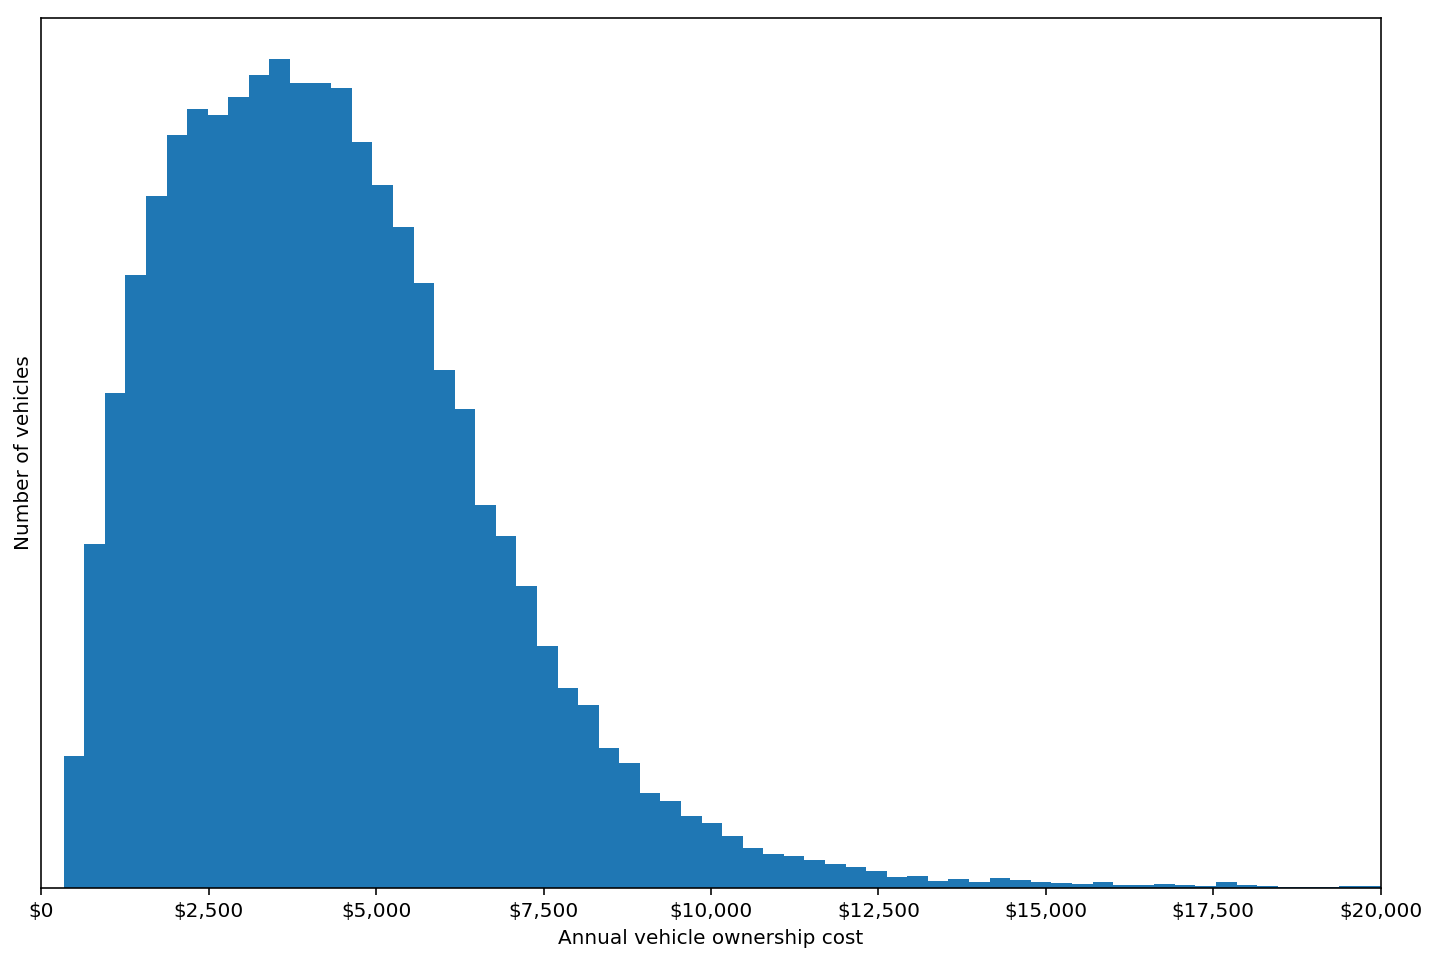

In [51]:
# [univariate histogram of annual per-vehicle ownership and use costs]
plt.figure(figsize=(12, 8))
plt.hist(data.totalCost, weights=data.WTHHFIN, bins=200)
histToCsv(data.totalCost, weights=data.WTHHFIN, bins=200, outputFile='../summary_output/annual_cost_per_vehicle_hist.csv')
plt.xlim(0, 20000)
plt.xticks(np.arange(0, 22000, 2500), [f'${i:,}' for i in range(0, 22000, 2500)])
plt.yticks([])
plt.xlabel('Annual vehicle ownership cost')
plt.ylabel('Number of vehicles')

Text(0,0.5,'Number of vehicles')

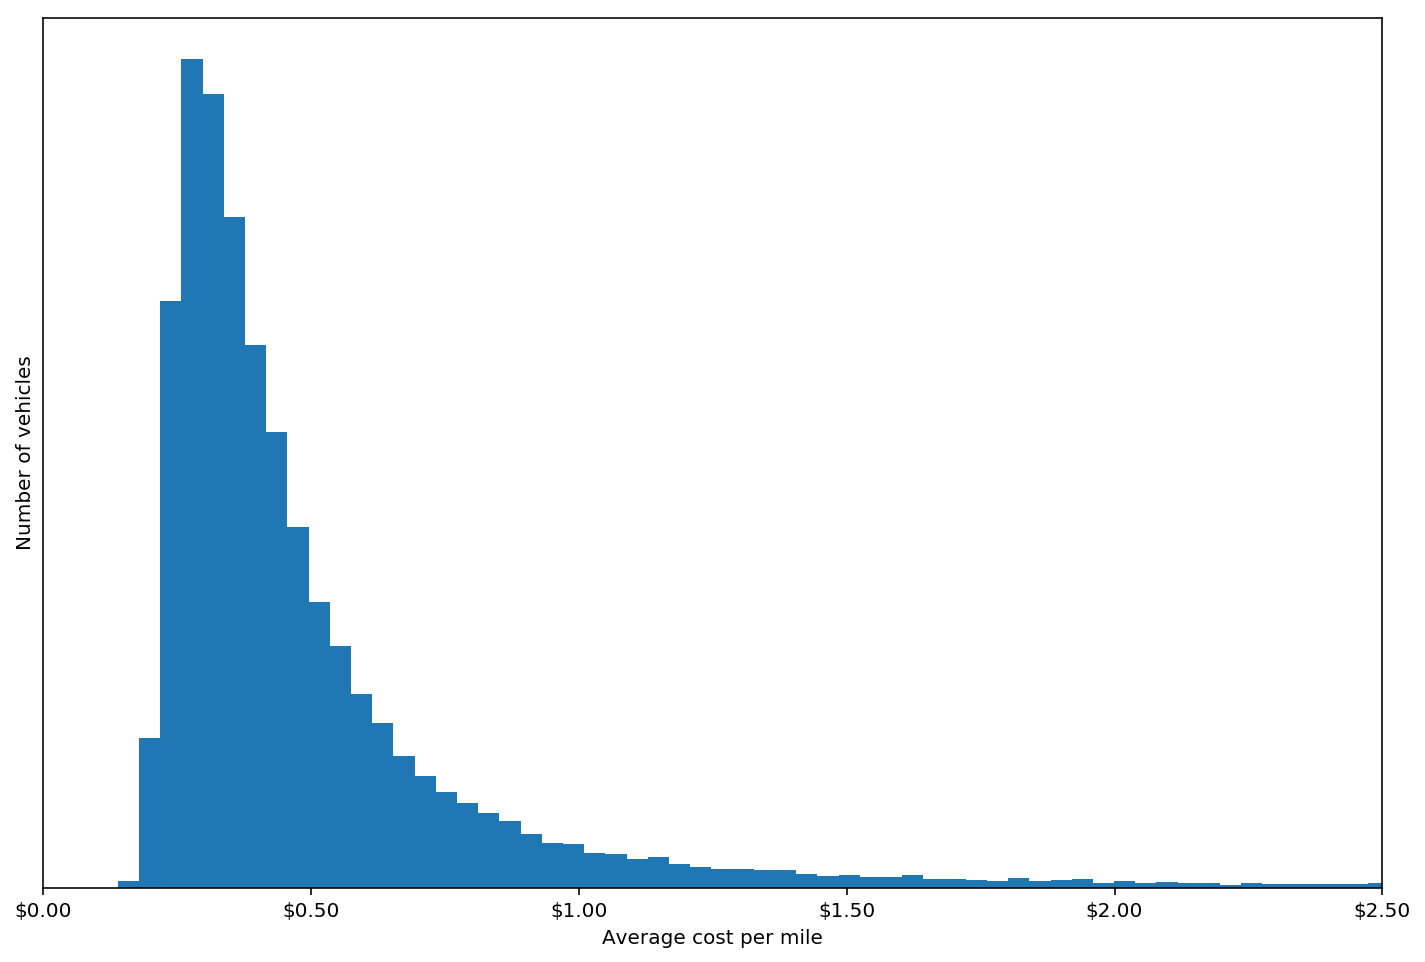

In [52]:
# [univariate histogram of annual per-mile ownership and use costs]
plt.figure(figsize=(12, 8))
plt.hist(data.averageCostPerMile, weights=data.WTHHFIN, bins=2000)
histToCsv(data.averageCostPerMile, weights=data.WTHHFIN, bins=2000, outputFile='../summary_output/average_cost_per_mile_hist.csv')
plt.xlim(0, 2.5)
plt.xticks(np.arange(0, 2.6, 0.5), [f'${i:.2f}' for i in np.arange(0, 2.6, 0.5)])
plt.yticks([])
plt.xlabel('Average cost per mile')
plt.ylabel('Number of vehicles')

Text(0,0.5,'Number of vehicles')

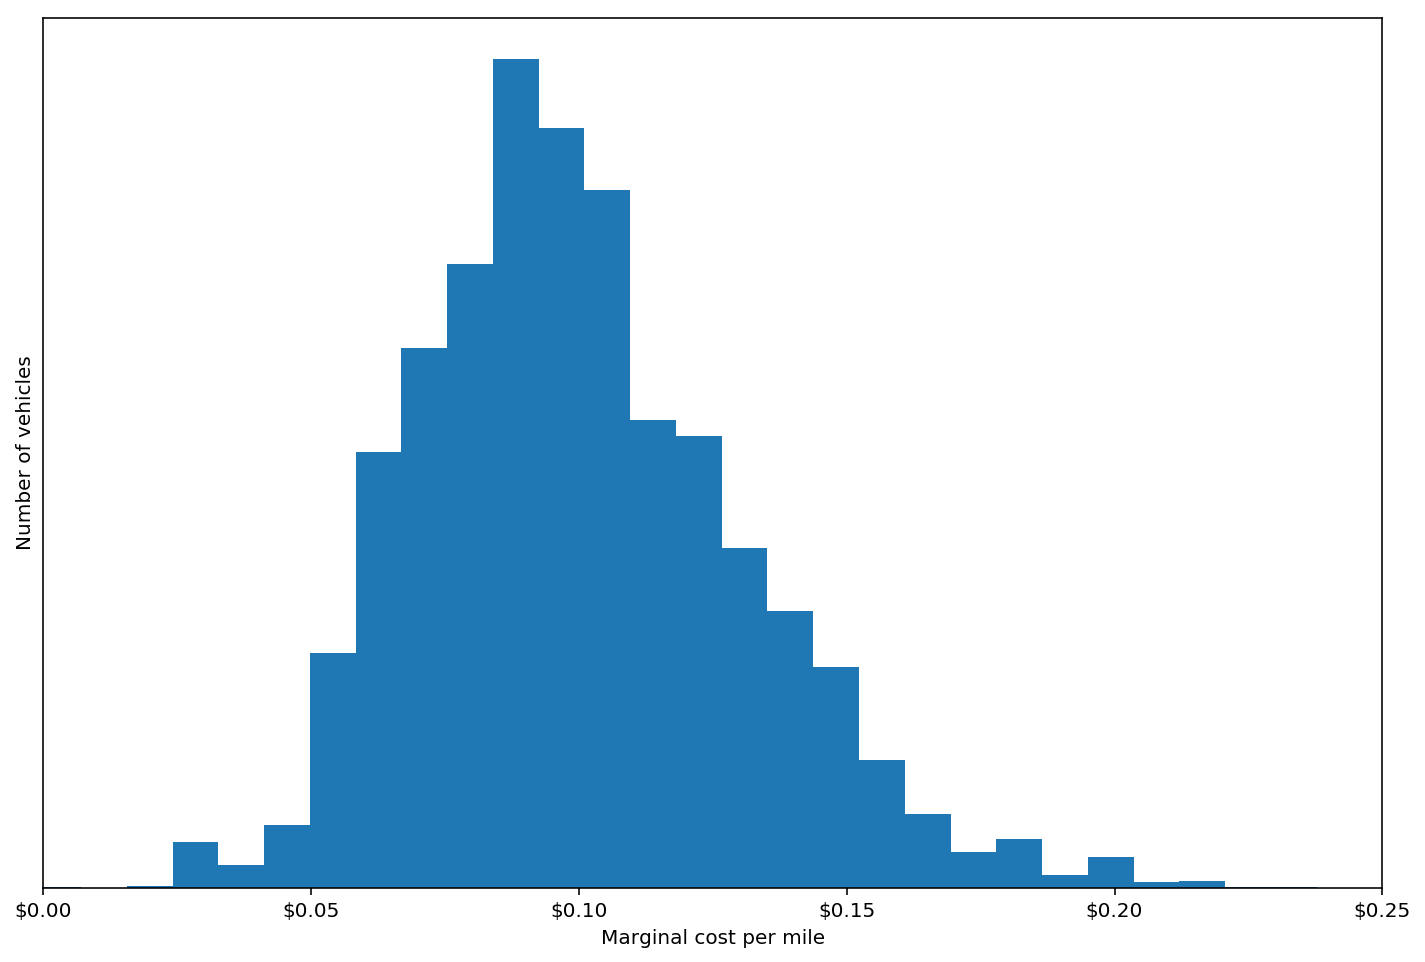

In [53]:
# [univariate histogram of annual per-mile ownership and use costs]
plt.figure(figsize=(12, 8))
plt.hist(data.marginalCostPerMile, weights=data.WTHHFIN, bins=30)
histToCsv(data.marginalCostPerMile, weights=data.WTHHFIN, bins=30, outputFile='../summary_output/marginal_cost_per_mile_hist.csv')
plt.xlim(0.1, 0.35)
plt.xticks(np.arange(0.1, 0.36, 0.05), [f'${i:.2f}' for i in np.arange(0, 0.36, 0.05)])
plt.yticks([])
plt.xlabel('Marginal cost per mile')
plt.ylabel('Number of vehicles')

In [12]:
# pull in person weights
pers = pd.read_csv('../data/nhts/perpub.csv').set_index(['HOUSEID', 'PERSONID'])
# whoMainGuess can be nan for vehicles in households with no drivers. There are 114 of these.
vehiclesWithPersonWeights = data[~pd.isnull(data.whoMainGuess)].merge(
    pers[['WTPERFIN']], left_on=['HOUSEID', 'whoMainGuess'], right_index=True,
    how='left', validate='m:1')
assert not np.any(pd.isnull(vehiclesWithPersonWeights.WTPERFIN))

In [13]:
# Compute an adjusted "vehicle-person" weight that is the person weight divided by the number of vehicles that
# they are the primary driver of, so that the averages below are over persons, not over vehicles
vehiclesPerPerson =\
    pd.DataFrame({'nVehiclesForDriver': vehiclesWithPersonWeights.groupby(['HOUSEID', 'whoMainGuess']).apply(len)})
vehiclesWithPersonWeights = vehiclesWithPersonWeights.merge(
    vehiclesPerPerson, left_on=['HOUSEID', 'whoMainGuess'], right_index=True,
    how='left', validate='m:1'
)
vehiclesWithPersonWeights['vehiclePersonWeight'] =\
    vehiclesWithPersonWeights.WTPERFIN / vehiclesWithPersonWeights.nVehiclesForDriver

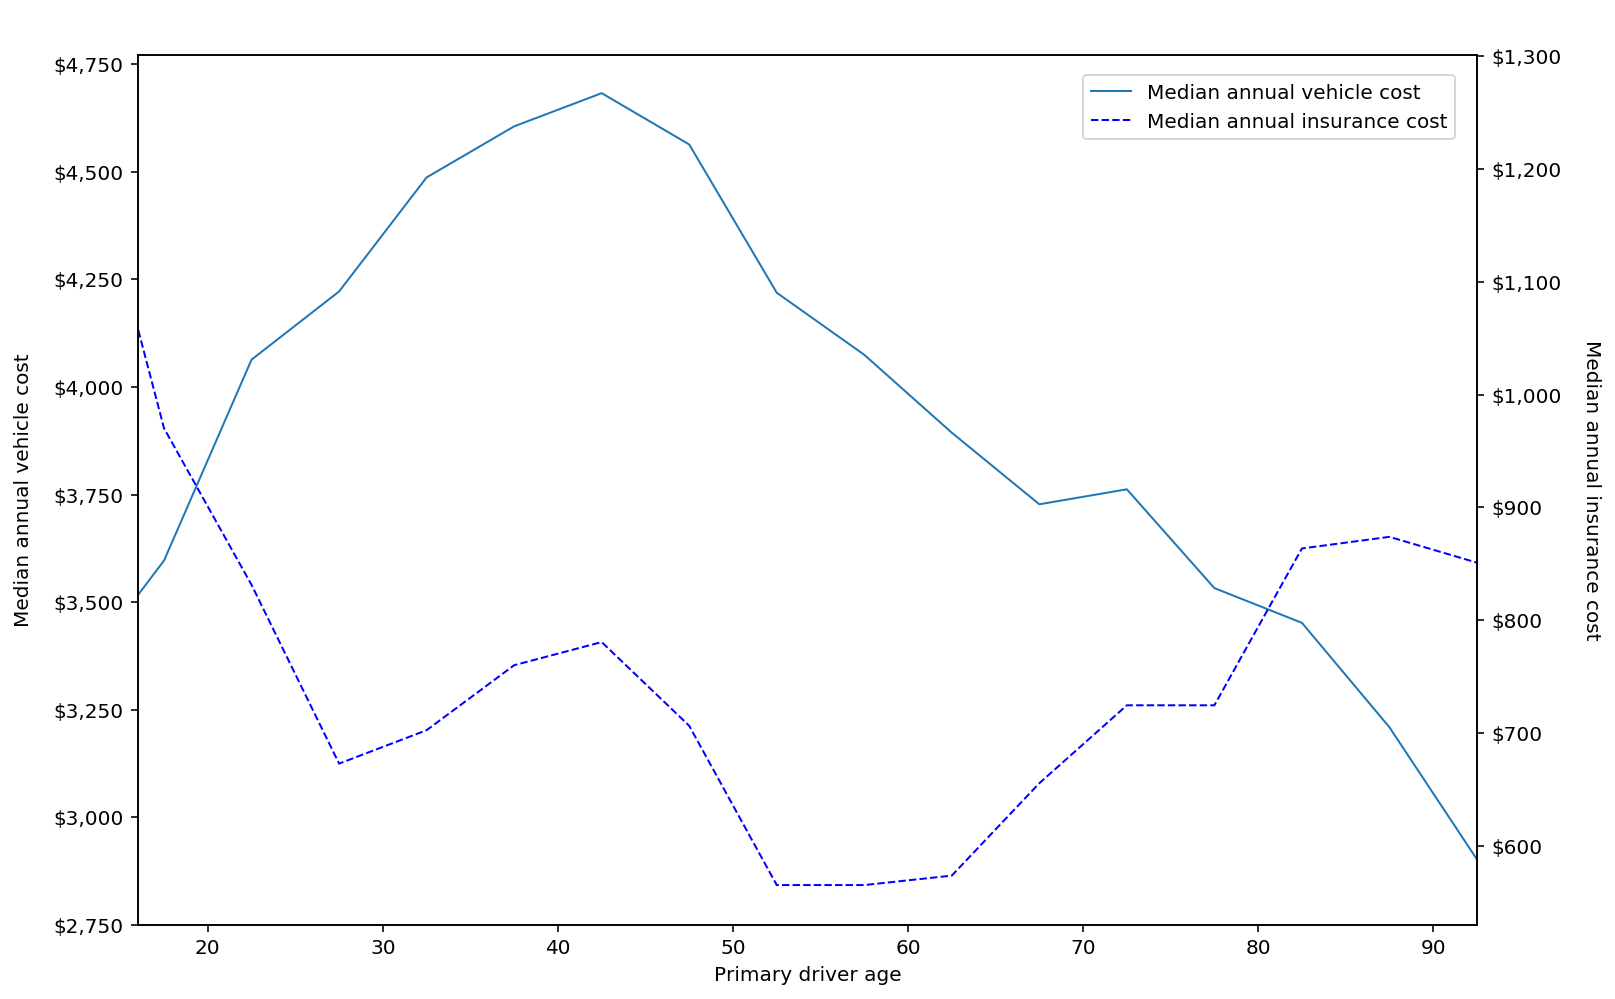

In [56]:
# [line graph for per-vehicle cost of ownership by age, ages 16+]
SMOOTHING = 5
vehiclesWithPersonWeights['aggAge'] = vehiclesWithPersonWeights.R_AGE_IMP // SMOOTHING * SMOOTHING + SMOOTHING / 2
f, totAx = plt.subplots(figsize=(12, 8))
byage = vehiclesWithPersonWeights.groupby('aggAge')\
    .apply(lambda df: weighted_percentile(df.totalCost, 50, df.vehiclePersonWeight))

totLine = totAx.plot(byage.index, byage, lw=1)
totAx.set_xlabel('Primary driver age')
totAx.set_ylabel('Median annual vehicle cost')
totAx.set_yticks(np.arange(2750, 4800, 250))
totAx.set_yticklabels([f'${i:,}' for i in range(2750, 4800, 250)])
totAx.yaxis.labelpad = 10

insbyage = vehiclesWithPersonWeights.groupby('aggAge')\
    .apply(lambda df: weighted_percentile(df.insuranceCostDiscounted, 50, df.vehiclePersonWeight))
insAx = totAx.twinx()
insLine = insAx.plot(insbyage.index, insbyage, color='blue', lw=1, ls='--')
insAx.set_yticks(np.arange(600, 1400, 100))
insAx.set_yticklabels([f'${i:,}' for i in range(600, 1400, 100)])
insAx.set_ylabel('Median annual insurance cost', rotation=270)
insAx.yaxis.labelpad = 20

# cutting off below 16; some states allow younger drivers but values will be highly variable because this is rare
totAx.set_xlim(16, np.max(insbyage.index.values))
plt.figlegend([*totLine, *insLine], ['Median annual vehicle cost', 'Median annual insurance cost'], (0.67, 0.86))

pd.DataFrame({
    'medianTotalCost': byage,
    'medianInsuranceCost': insbyage
}).reset_index().rename(columns={'aggAge': 'ageCategoryMidpoint'})\
.to_csv('../summary_output/cost_by_age.csv')

In [36]:
vehiclesWithPersonWeights['income'] = vehiclesWithPersonWeights.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$10,000',
    2: '\$10,000 to \$14,999',
    3: '\$15,000 to \$24,999',
    4: '\$25,000 to \$34,999',
    5: '\$35,000 to \$49,999',
    6: '\$50,000 to \$74,999',
    7: '\$75,000 to \$99,999',
    8: '\$100,000 to \$124,999',
    9: '\$125,000 to \$149,999',
    10: '\$150,000 to \$199,999',
    11: '\$200,000 or more'
}).astype('category').cat.reorder_categories([
    'Less than \$10,000',
    '\$10,000 to \$14,999',
    '\$15,000 to \$24,999',
    '\$25,000 to \$34,999',
    '\$35,000 to \$49,999',
    '\$50,000 to \$74,999',
    '\$75,000 to \$99,999',
    '\$100,000 to \$124,999',
    '\$125,000 to \$149,999',
    '\$150,000 to \$199,999',
    '\$200,000 or more'
])

# https://en.wikipedia.org/wiki/Jeanne_Calment
vehiclesWithPersonWeights['rAgeCat'] =\
    pd.cut(vehiclesWithPersonWeights.R_AGE_IMP, bins=[14, 20, 30, 40, 50, 60, 70, 80, 124], right=False)\
        .apply(lambda c: f'{c.left}–{c.right - 1}' if c.left < 80 else '80+')

vehiclesWithPersonWeights['vehAgeBar'] = vehiclesWithPersonWeights.age.apply(lambda x: int(x) if x <= 30 else None)

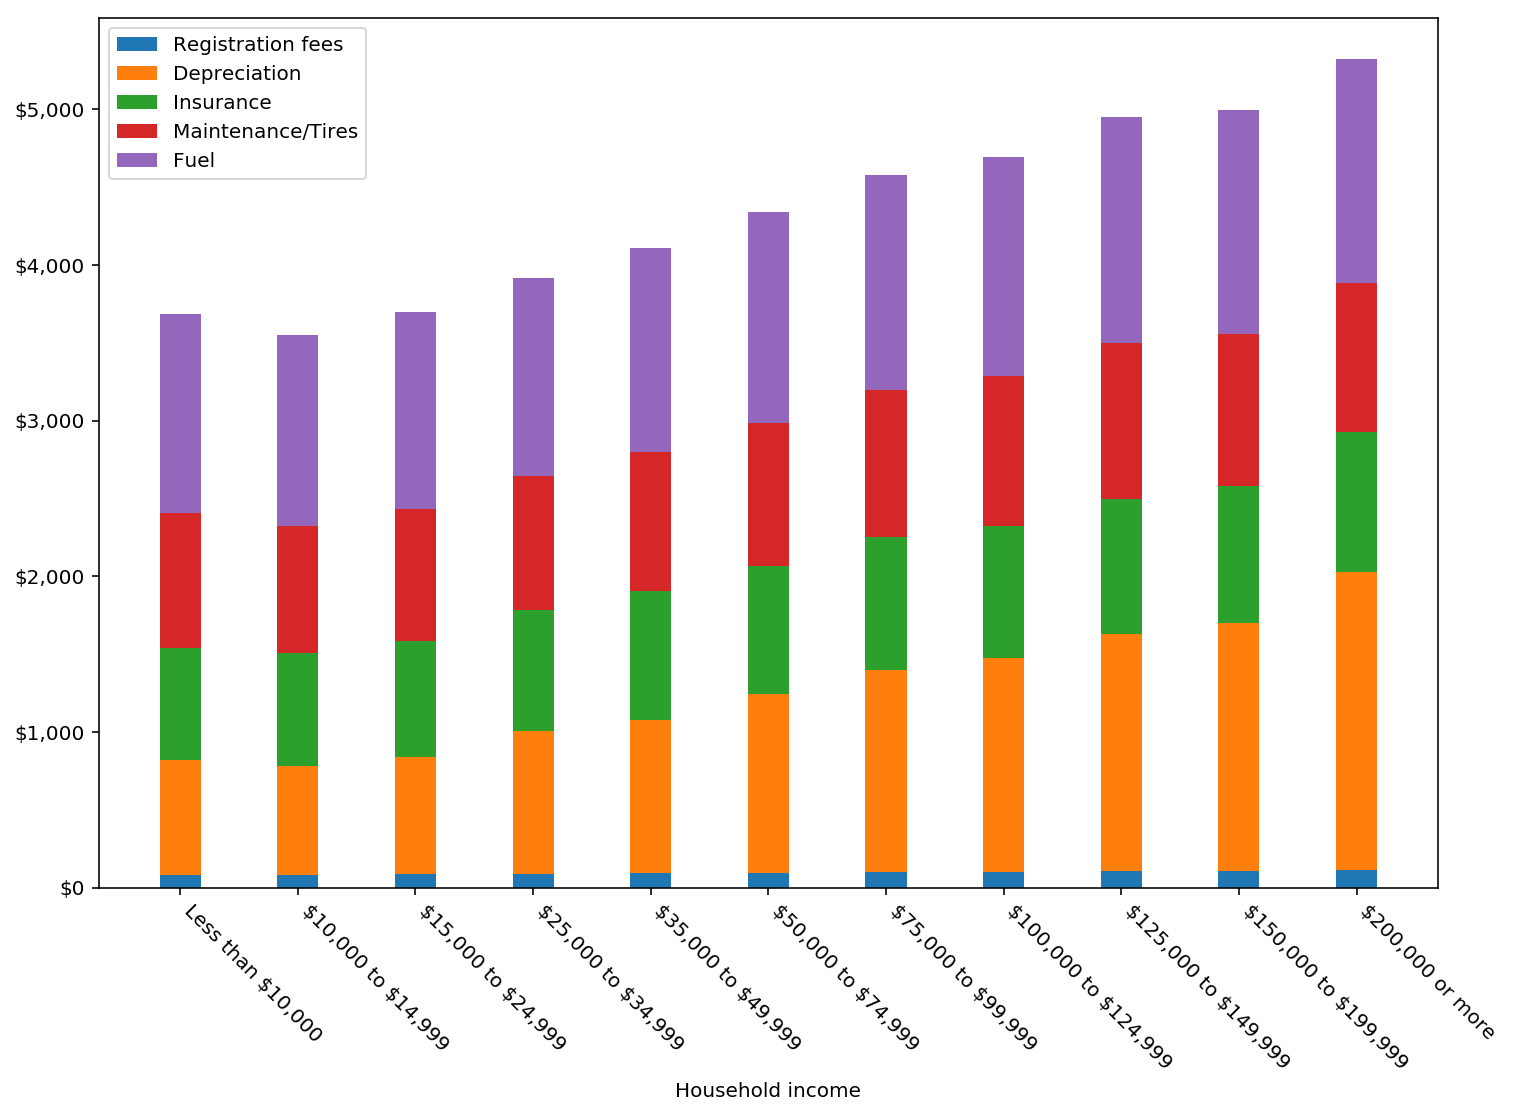

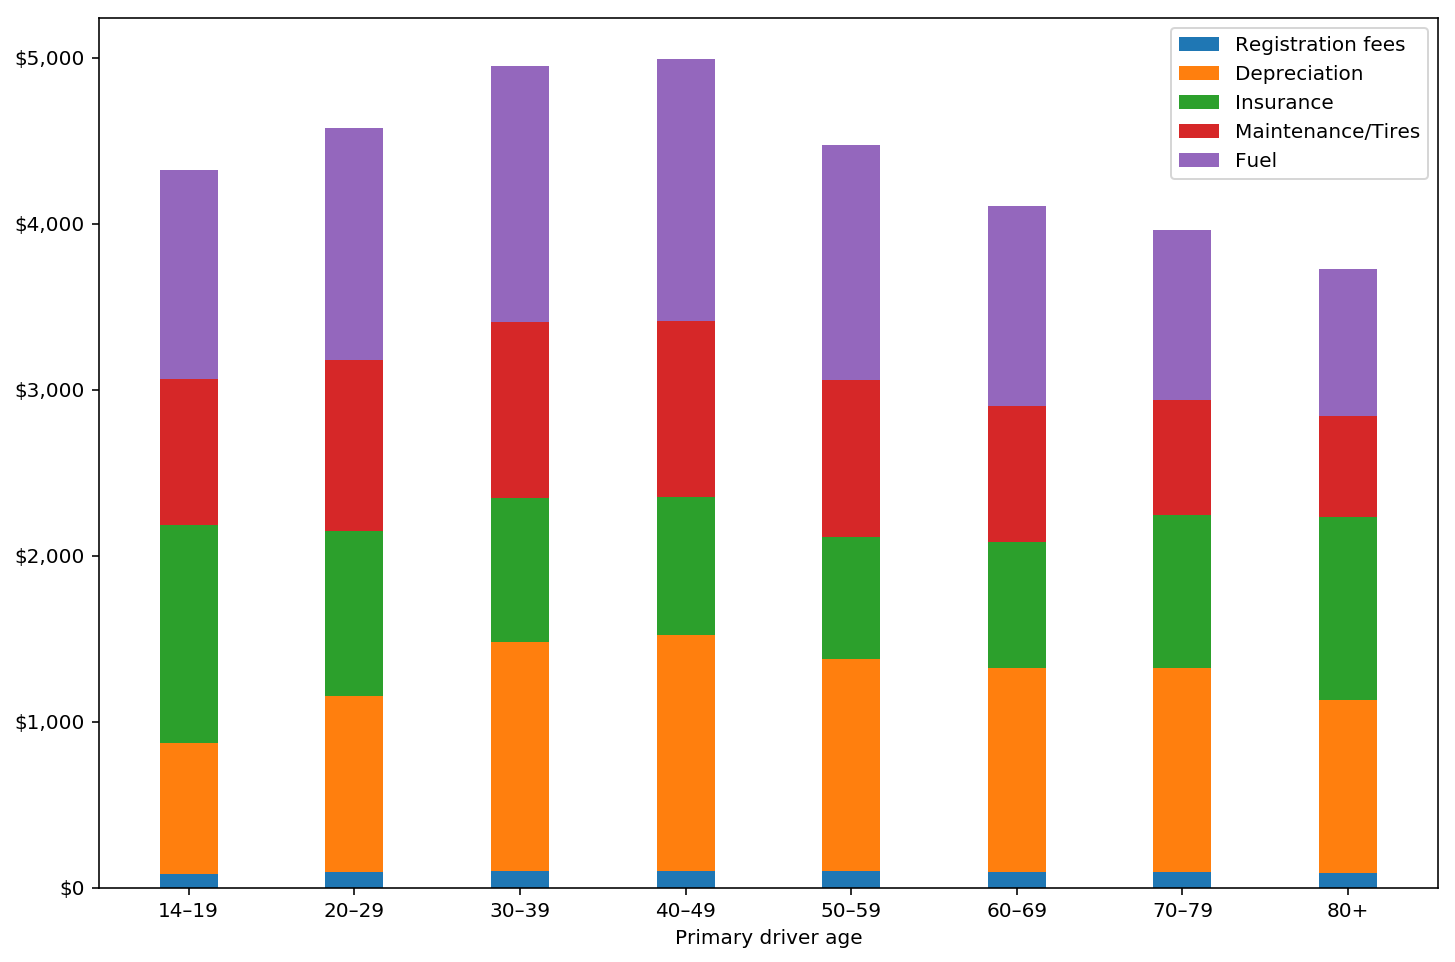

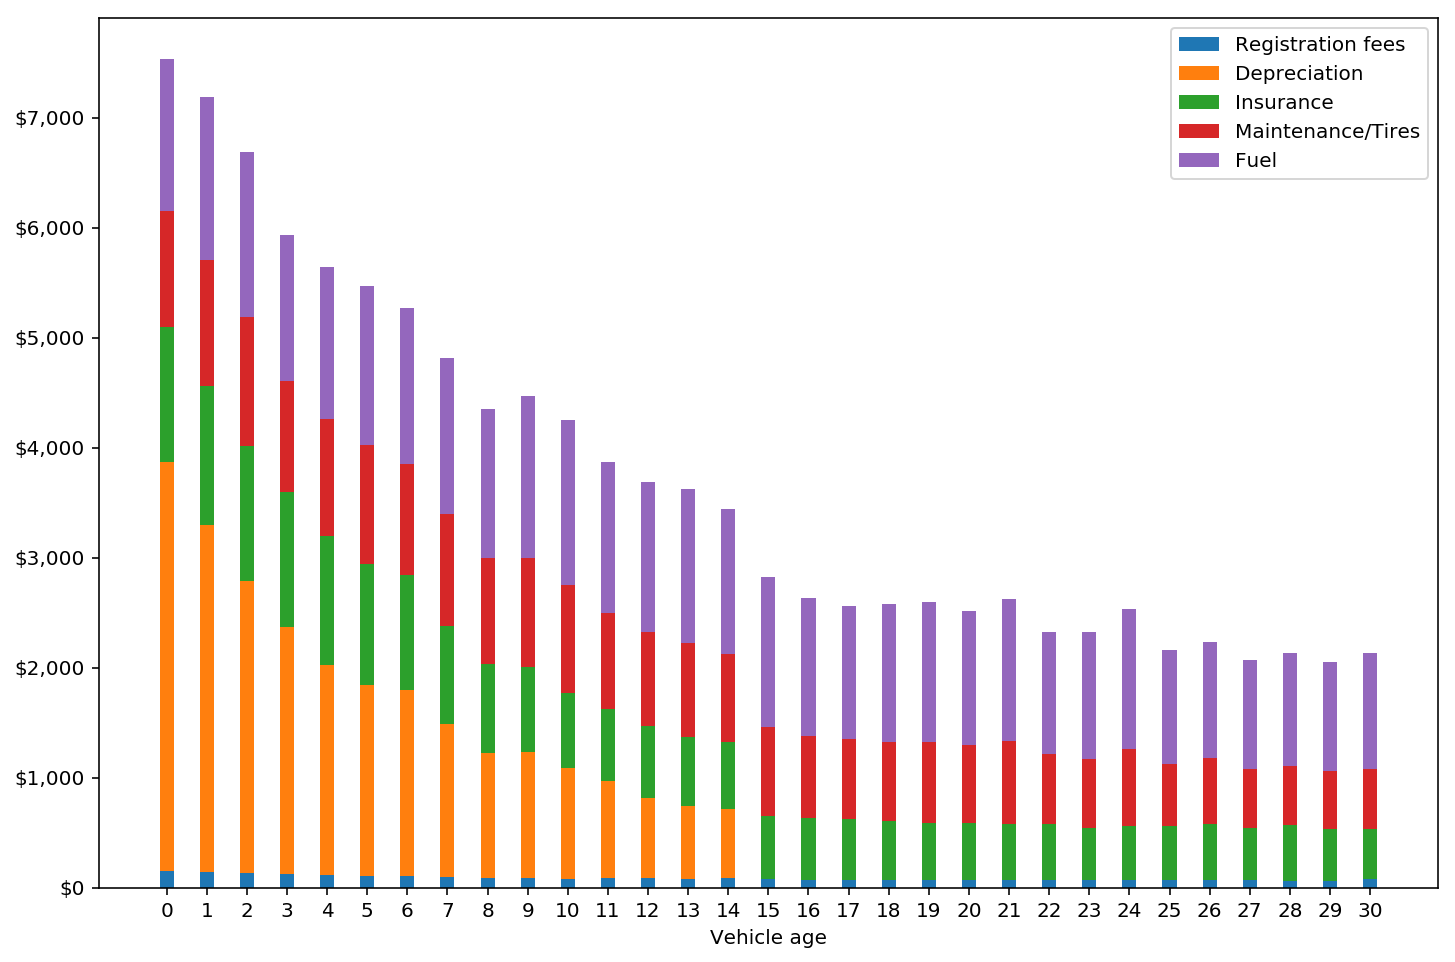

In [58]:
costComponents = ['regfee', 'annualDepreciation', 'insuranceCostDiscounted', 'maintenanceTireCost', 'fuelCost']

costComponentLabels = {
    'regfee': 'Registration fees',
    'annualDepreciation': 'Depreciation',
    'insuranceCostDiscounted': 'Insurance',
    'maintenanceTireCost': 'Maintenance/Tires',
    'fuelCost': 'Fuel'
}

for cat, weight, label, csvFile, ticks in (
        ('income', 'WTHHFIN', 'Household income', 'cost_components_by_hh_income.csv', { 'rotation': '-45', 'ha': 'left'}),
        ('rAgeCat', 'vehiclePersonWeight', 'Primary driver age', 'cost_components_by_primary_driver_age.csv', {}),
        ('vehAgeBar', 'WTPERFIN', 'Vehicle age', 'cost_components_by_vehicle_age.csv', {})
    ):
    
    # TODO remove regfee
    relevant = vehiclesWithPersonWeights[~pd.isnull(vehiclesWithPersonWeights[cat]) & ~pd.isnull(vehiclesWithPersonWeights.regfee)]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    costs = dict()
    
    for cost in costComponents:
        # NB using mean not median because mean(A) + mean(B) == mean(A + B), not true for medians
        costs[cost] = relevant.groupby(cat).apply(lambda x: np.average(x[cost], weights=x[weight]))
        
    cumulativeCost = pd.Series(np.zeros_like(costs['annualDepreciation']), index=costs['annualDepreciation'].index)
    for cost in costComponents:
        # https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
        costVals = costs[cost]
        plt.bar(np.arange(0, len(costVals)), costVals, 0.35, bottom=cumulativeCost, label=costComponentLabels[cost])
        tickLabels = costVals.index.values.astype(int) if cat == 'vehAgeBar' else costVals.index.values
        plt.xticks(np.arange(0, len(costVals)), tickLabels, **ticks)
        cumulativeCost += costVals
        
    plt.xlabel(label)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${int(x):,}'))
    plt.legend()
    
    pd.DataFrame(costs).reset_index().rename(columns={
        'rAgeCat': 'driverAgeCategory',
        'vehAgeBar': 'vehicleAge'
    }).to_csv('../summary_output/' + csvFile, index=False)
    

## Household costs

Join with household file to get household costs (including for zero-vehicle families)

In [18]:
households['totalCost'] = data.groupby('HOUSEID').totalCost.apply(np.sum)
households['totalCost'] = households.totalCost.fillna(0)

In [19]:
# exclude households with dropped vehicles
households['eligibleVehCount'] = vehiclesPreDrop.groupby('HOUSEID').VEHID.apply(len)
households['eligibleVehCount'] = households.eligibleVehCount.fillna(0)
households['retainedVehCount'] = data.groupby('HOUSEID').VEHID.apply(len)
households['retainedVehCount'] = households.retainedVehCount.fillna(0)
print(f'dropping {np.sum(households.retainedVehCount != households.eligibleVehCount)} due to dropped vehicles')
households = households[households.retainedVehCount == households.eligibleVehCount].copy()

dropping 4208 due to dropped vehicles


In [20]:
# save mapping data
stateMedians = households.groupby('HHSTATE').apply(lambda df: weighted_percentile(df.totalCost, 50, df.WTHHFIN))
stateMedians.reset_index().rename(columns={0: 'medianCost'}).to_csv('../summary_output/state_median_costs.csv')

Text(0,0.5,'Number of households')

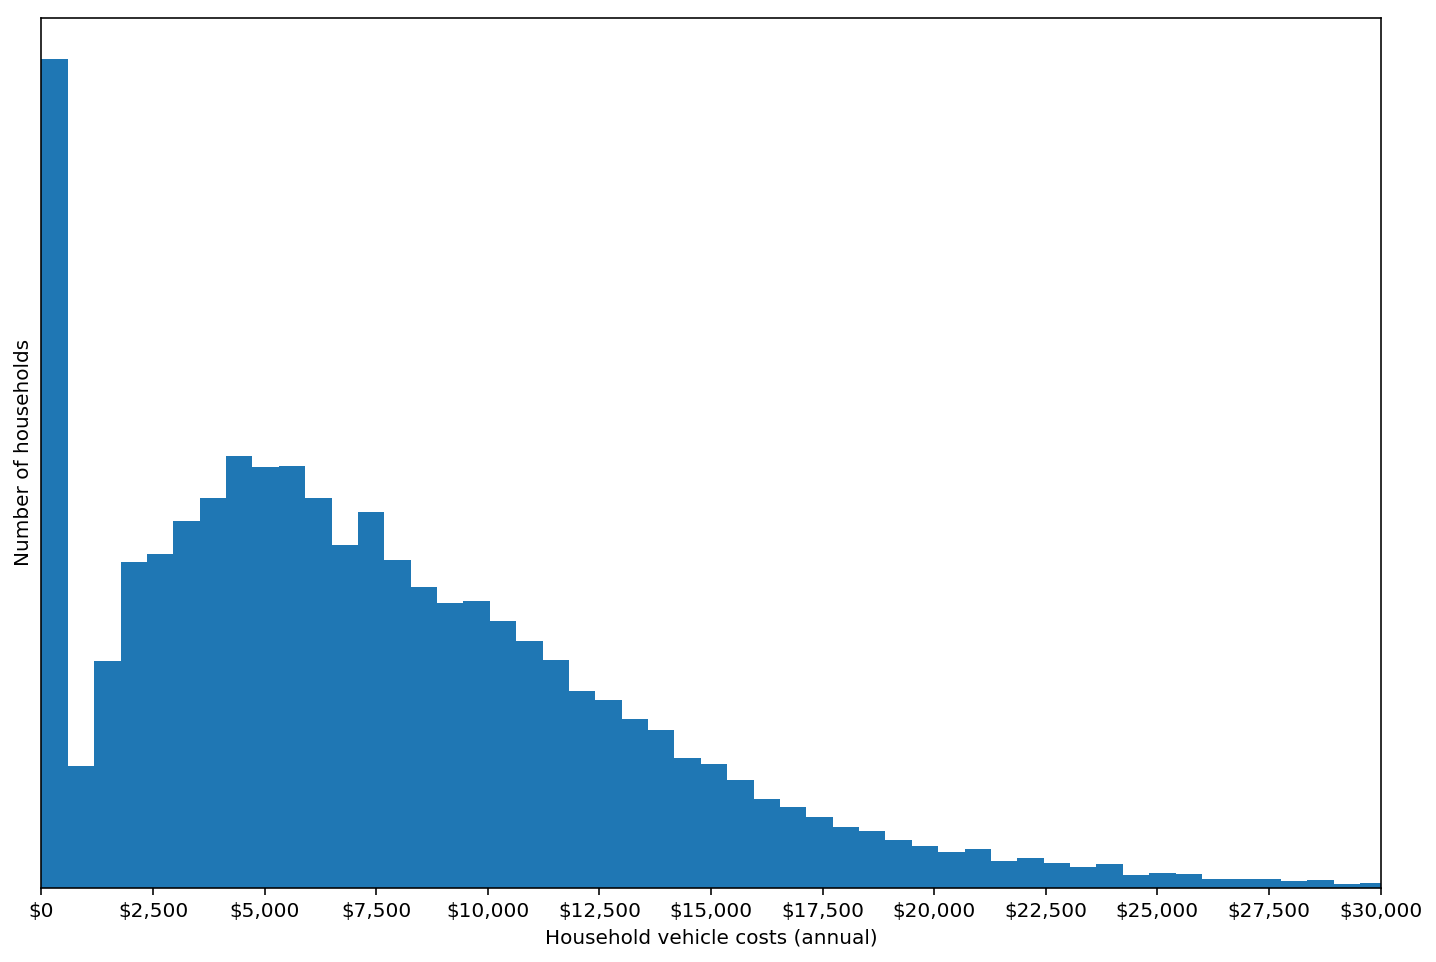

In [59]:
# univariate histogram of annual household vehicle ownership and use costs
plt.figure(figsize=(12, 8))
plt.hist(households.totalCost, weights=households.WTHHFIN, bins=200)
histToCsv(households.totalCost, weights=households.WTHHFIN, bins=200, outputFile='../summary_output/household_cost_hist.csv')
plt.yticks([])
plt.xticks(np.arange(0, 35000, 2500), [f'${i:,}' for i in range(0, 32000, 2500)])
plt.xlim(0, 30000)
plt.xlabel('Household vehicle costs (annual)')
plt.ylabel('Number of households')

In [22]:
households['income'] = households.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $10,000',
    2: '$10,000 to $14,999',
    3: '$15,000 to $24,999',
    4: '$25,000 to $34,999',
    5: '$35,000 to $49,999',
    6: '$50,000 to $74,999',
    7: '$75,000 to $99,999',
    8: '$100,000 to $124,999',
    9: '$125,000 to $149,999',
    10: '$150,000 to $199,999',
    11: '$200,000 or more'
}).astype('category').cat.reorder_categories([
    'Less than $10,000',
    '$10,000 to $14,999',
    '$15,000 to $24,999',
    '$25,000 to $34,999',
    '$35,000 to $49,999',
    '$50,000 to $74,999',
    '$75,000 to $99,999',
    '$100,000 to $124,999',
    '$125,000 to $149,999',
    '$150,000 to $199,999',
    '$200,000 or more'
])

households['incomeMiddle'] = households.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 5000,
    2: 12500,
    3: 20000,
    4: 32000,
    5: 42500,
    6: 62500,
    7: 87500,
    8: 112500,
    9: 137500,
    10: 175000,
    11: 225000
}).astype('float64')

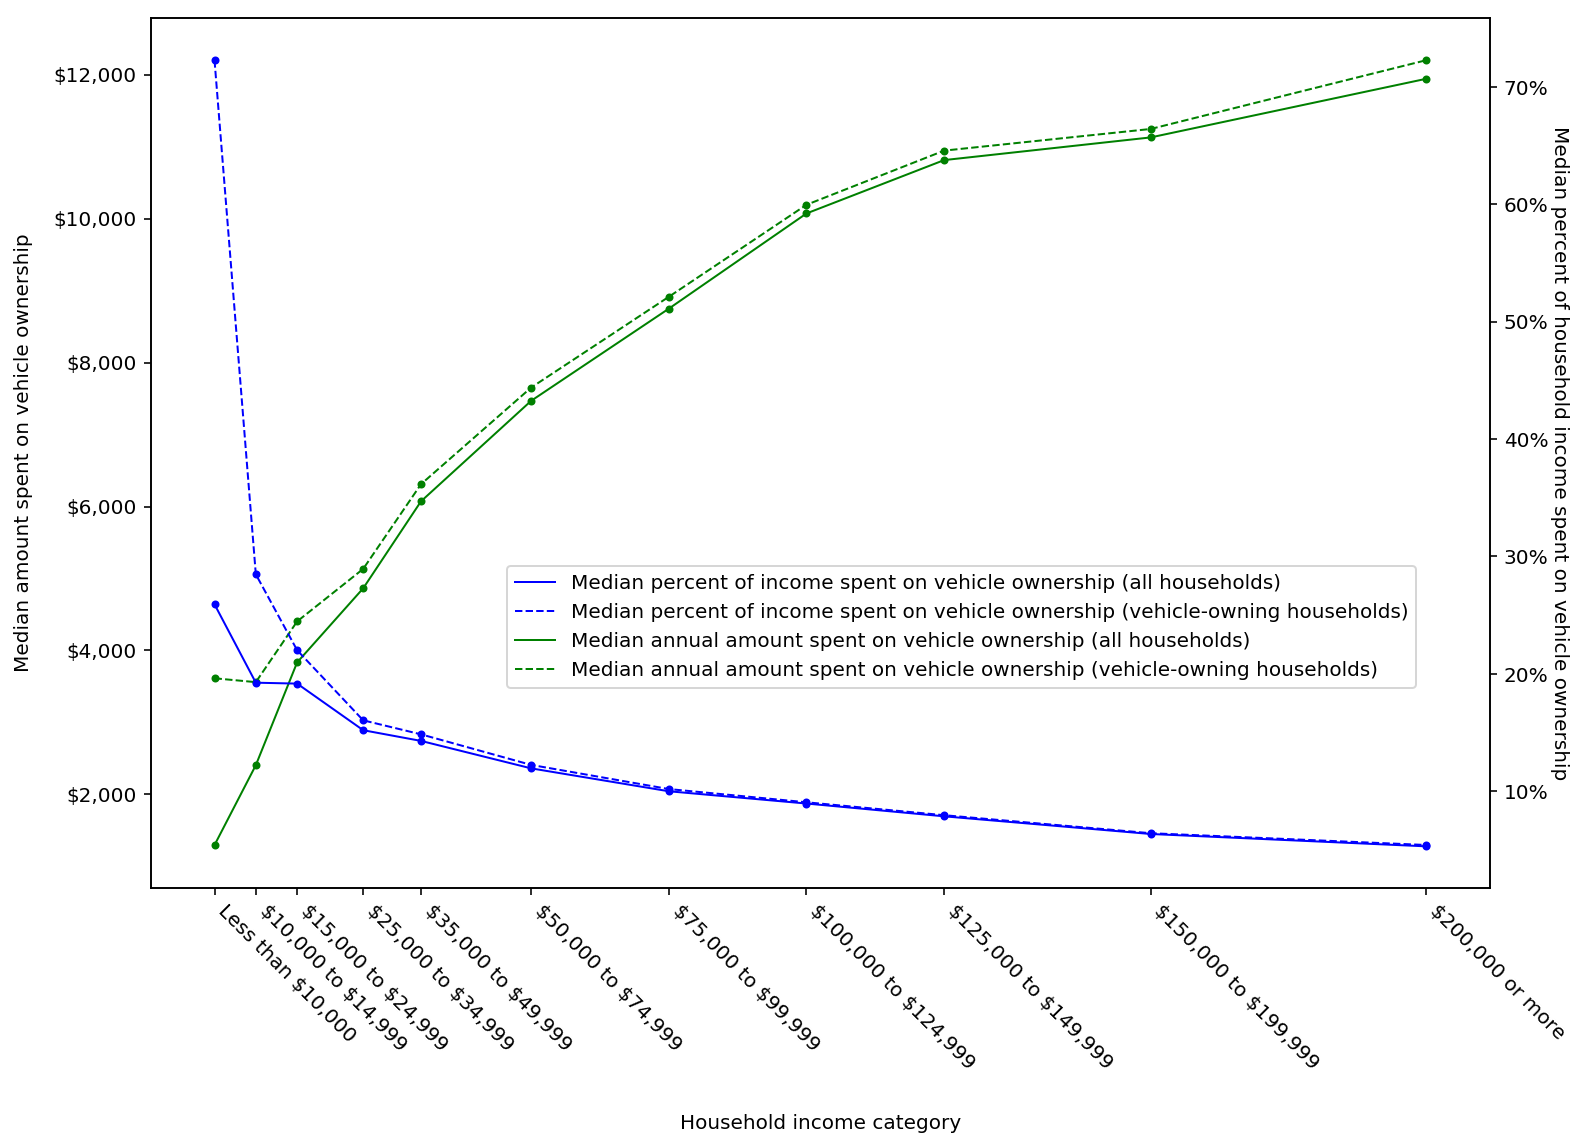

In [64]:
# [percent of household income spent on vehicle ownership and use + total spent on all household vehicles
#  (income on x axis, 2 y axes) - mwc]

# https://matplotlib.org/examples/api/two_scales.html
fig, totalAx = plt.subplots(figsize=(12, 8))
pctAx = totalAx.twinx()

# compute percent of income spent on vehicles, using middle of income range
households['pctIncome'] = households.totalCost / households.incomeMiddle

hhInc = households[~pd.isnull(households.income)]
hhIncCars = households[~pd.isnull(households.income) & (households.retainedVehCount > 0)]

pctLines = []
pctLabels = []
totLines = []
totLabels = []

pctOutput = {}
totOutput = {}

for hhsub, ls, label, shortLabel in ((hhInc, '-', 'all households', 'allHouseholds'), (hhIncCars, '--', 'vehicle-owning households', 'vehicleOwningHouseholds')):
    pct = hhsub.groupby('incomeMiddle').apply(lambda df: weighted_percentile(df.pctIncome, 50, df.WTHHFIN))
    pctLabels.append(f'Median percent of income spent on vehicle ownership ({label})')
    pctLines.append(*pctAx.plot(pct.index, pct, ls=ls, color='blue', lw=1))
    pctAx.scatter(pct.index, pct, color='blue', marker='.')
    pctOutput[shortLabel] = pct
    
    tot = hhsub.groupby('incomeMiddle').apply(lambda df: weighted_percentile(df.totalCost, 50, df.WTHHFIN))
    totLabels.append(f'Median annual amount spent on vehicle ownership ({label})')
    totLines.append(*totalAx.plot(tot.index, tot, ls=ls, color='green', lw=1))
    totalAx.scatter(tot.index, tot, color='green', marker='.')
    totOutput[shortLabel] = tot
    
totalAx.set_xticks(np.array([
    5000,
    12500,
    20000,
    32000,
    42500,
    62500,
    87500,
    112500,
    137500,
    175000,
    225000
]))

totalAx.set_xticklabels([
    'Less than \$10,000',
    '\$10,000 to \$14,999',
    '\$15,000 to \$24,999',
    '\$25,000 to \$34,999',
    '\$35,000 to \$49,999',
    '\$50,000 to \$74,999',
    '\$75,000 to \$99,999',
    '\$100,000 to \$124,999',
    '\$125,000 to \$149,999',
    '\$150,000 to \$199,999',
    '\$200,000 or more'
], rotation = -45, ha='left')

pctAx.set_yticks(np.arange(0.1, 0.8, 0.1))
pctAx.set_yticklabels([f'{int(i * 100)}%' for i in np.arange(0.1, 0.8, 0.1)])
pctAx.yaxis.labelpad = 10

totalAx.set_yticks(np.arange(2000, 13000, 2000))
totalAx.set_yticklabels([f'${i:,}' for i in range(2000, 13000, 2000)])
# https://stackoverflow.com/questions/6406368/matplotlib-move-x-axis-label-downwards-but-not-x-axis-ticks
totalAx.yaxis.labelpad = 10
pctAx.set_ylabel('Median percent of household income spent on vehicle ownership', rotation=270)
totalAx.set_ylabel('Median amount spent on vehicle ownership')
totalAx.set_xlabel('Household income category')
totalAx.xaxis.labelpad = 20

plt.figlegend([*pctLines, *totLines], [*pctLabels, *totLabels], (0.32, 0.4))

pd.DataFrame({k: v * 100 for k, v in pctOutput.items()}).reset_index()\
              .rename(columns={'incomeMiddle': 'incomeCategoryMidpoint'})\
    .to_csv('../summary_output/percent_hh_income_spent_on_vehicles_by_income.csv', index=False)

pd.DataFrame(totOutput).reset_index().rename(columns={'incomeMiddle': 'incomeCategoryMidpoint'})\
    .to_csv('../summary_output/amount_spent_on_vehicles_by_income.csv', index=False)

## Density

Do respondents in dense areas spend less?

In [24]:
households['density'] = households.HBPPOPDN.replace({
    50: '0–99 persons/sq. mi.',
    300: '100–499 persons/sq. mi.',
    750: '500–999 persons/sq. mi.',
    1500: '1,000–1,999 persons/sq. mi.',
    3000: '2,000–3,999 persons/sq. mi.',
    7000: '4,000–9,999 persons/sq. mi.',
    17000: '10,000–24,999 persons/sq. mi.',
    30000: '> 25,000 persons/sq. mi.',
    -9: np.nan
}).astype('category').cat.reorder_categories([
    '0–99 persons/sq. mi.',
    '100–499 persons/sq. mi.',
    '500–999 persons/sq. mi.',
    '1,000–1,999 persons/sq. mi.',
    '2,000–3,999 persons/sq. mi.',
    '4,000–9,999 persons/sq. mi.',
    '10,000–24,999 persons/sq. mi.',
    '> 25,000 persons/sq. mi.'
])

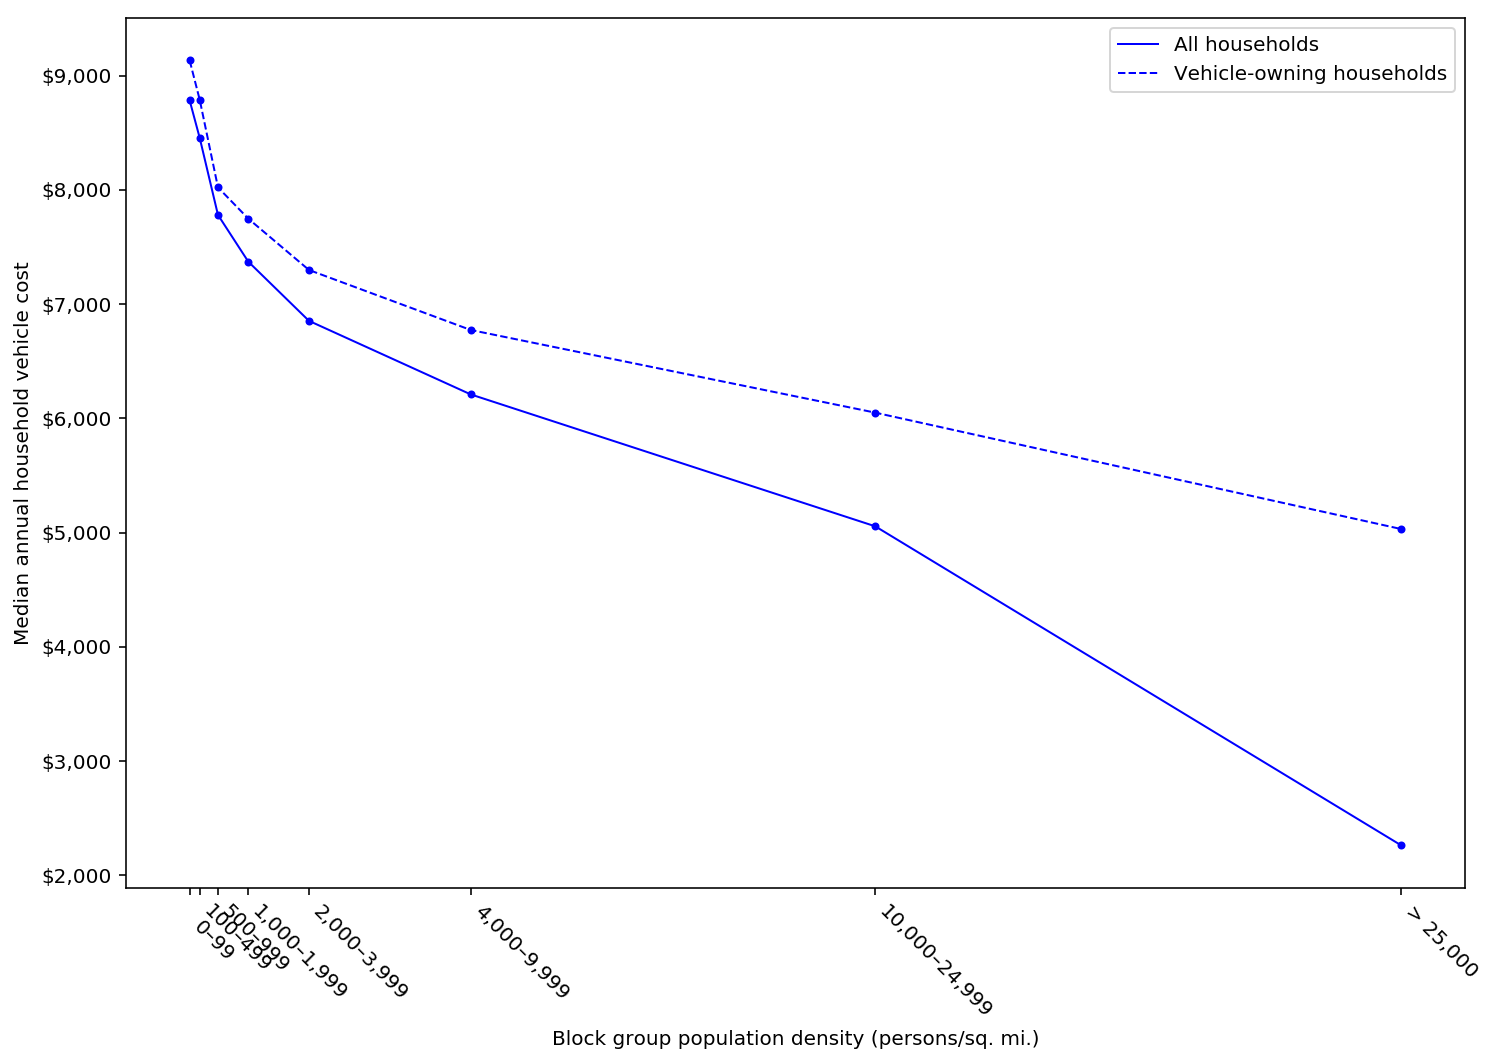

In [66]:
plt.figure(figsize=(12, 8))
costByDensity = households[~pd.isnull(households.density)].groupby('density')\
    .apply(lambda x: weighted_percentile(x.totalCost, 50, x.WTHHFIN))\
    .sort_index()

idxes = np.sort(households.HBPPOPDN[households.HBPPOPDN > 0].unique())

plt.plot(idxes, costByDensity, color='blue', label='All households', lw=1)
plt.scatter(idxes, costByDensity, color='blue', marker='.')

costByDensityVeh = households[~pd.isnull(households.density) & (households.retainedVehCount > 0)].groupby('density')\
    .apply(lambda x: weighted_percentile(x.totalCost, 50, x.WTHHFIN))\
    .sort_index()


plt.plot(idxes, costByDensityVeh, color='blue', ls='--', label='Vehicle-owning households', lw=1)
plt.scatter(idxes, costByDensityVeh, color='blue', marker='.')

plt.xlabel('Block group population density (persons/sq. mi.)')
plt.ylabel('Median annual household vehicle cost')

labels = [i.replace(' persons/sq. mi.', '') for i in costByDensity.index]

# HACK TO GET LABELS TO NOT OVERLAP
labels[0] = '\n' + labels[0]

plt.xticks(idxes, labels, rotation=-45, ha='left')

plt.yticks(np.arange(2000, 9100, 1000), [f'${i:,}' for i in range(2000, 9100, 1000)])

plt.legend()

pd.DataFrame({
    'costByDensityAllHouseholds': costByDensity,
    'costByDensityVehicleOwningHouseholds': costByDensityVeh
}).reset_index().to_csv('../summary_output/household_vehicle_cost_by_density.csv', index=False)

([<matplotlib.axis.YTick at 0x12aba7748>,
 <a list of 9 Text yticklabel objects>)

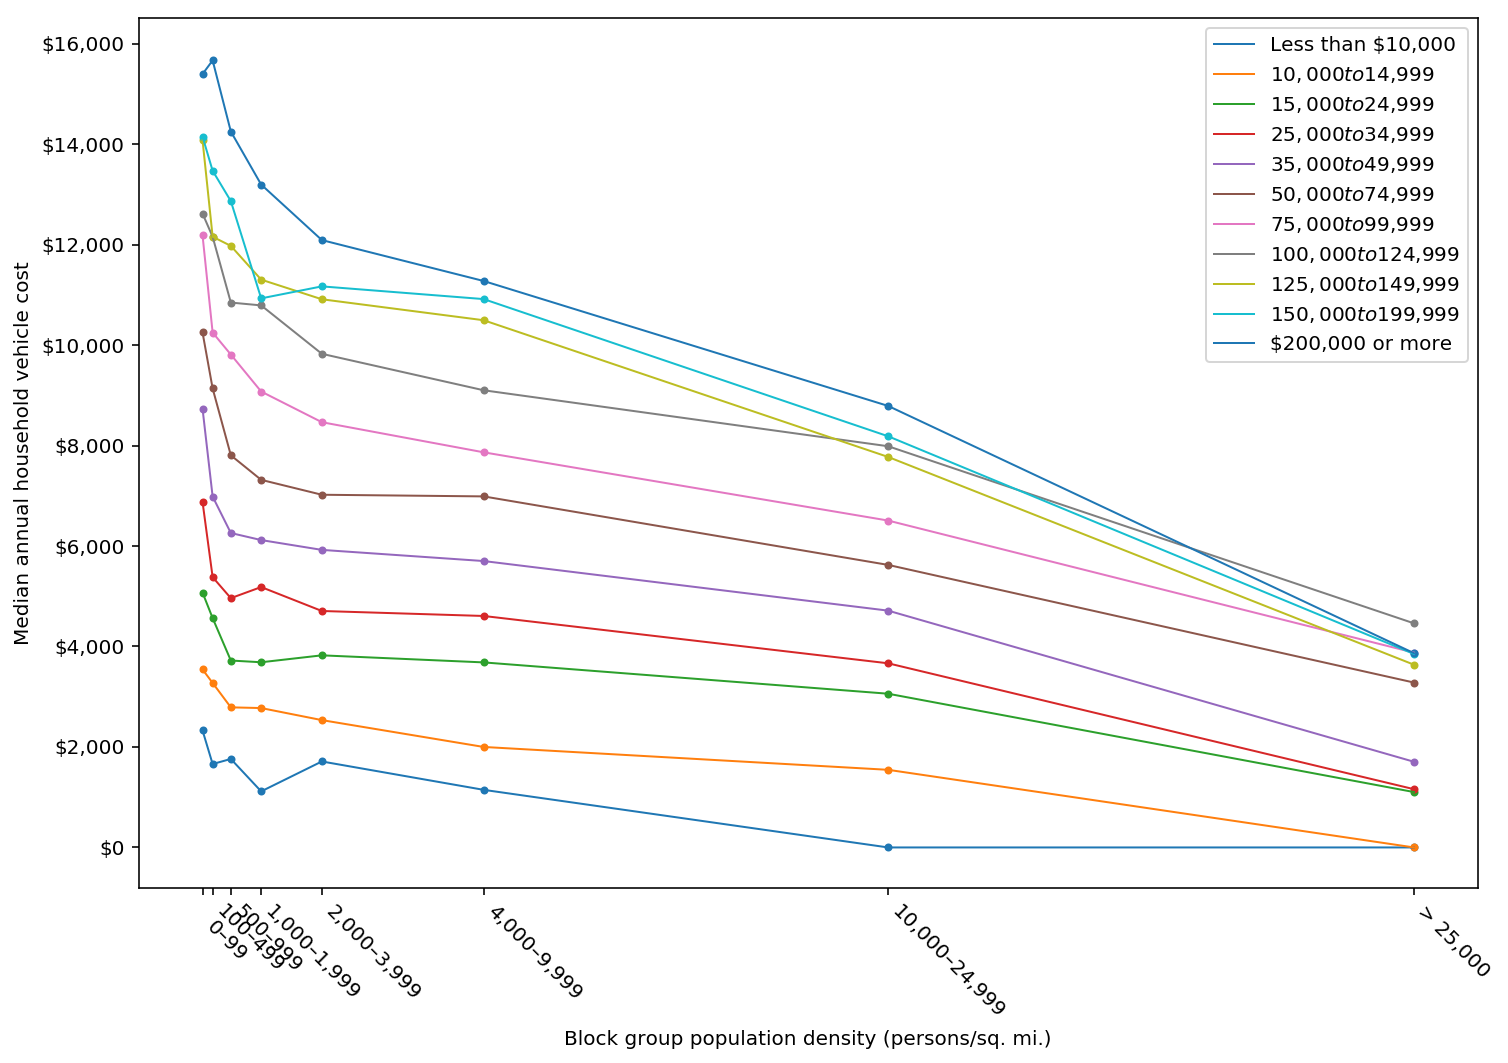

In [26]:
plt.figure(figsize=(12, 8))
idxes = np.sort(households.HBPPOPDN[households.HBPPOPDN > 0].unique())
for incomeCategory in households.income.cat.categories:
    costByDensity = households[~pd.isnull(households.density) & (households.income==incomeCategory)].groupby('density')\
        .apply(lambda x: weighted_percentile(x.totalCost, 50, x.WTHHFIN))\
        .sort_index()
    
    plt.plot(idxes, costByDensity, label=incomeCategory, lw=1)
    plt.scatter(idxes, costByDensity, marker='.')
    labels = [i.replace(' persons/sq. mi.', '') for i in costByDensity.index]

    # HACK TO GET LABELS TO NOT OVERLAP
    labels[0] = '\n' + labels[0]

    plt.xticks(idxes, labels, rotation=-45, ha='left')
    
plt.legend()
plt.xlabel('Block group population density (persons/sq. mi.)')
plt.ylabel('Median annual household vehicle cost')

plt.yticks(np.arange(0, 16100, 2000), [f'${i:,}' for i in range(0, 16100, 2000)])


## Look a bit more closely at vehicle shedding potential

What are the attributes of vehicles that have high operating costs (greater than a low estimate for ridehailing costs).

In [29]:
sheddable = vehiclesWithPersonWeights[(vehiclesWithPersonWeights.averageCostPerMile >= 1.50) & (vehiclesWithPersonWeights.age < 1000)].copy()

(array([1186688.41103781, 2049444.87157933, 1226061.37577188,
        1034148.30868014,  802743.98564018, 1001735.10943924,
         983432.11310872,  515819.53684052,  283808.07510831,
         233452.8383156 ,  132497.31824531,   94188.4406531 ,
          44477.56014403,   42127.95769798,   30329.77443328,
          27860.62715655,    3624.32109563,       0.        ,
              0.        ,  170492.93656489]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40.]),
 <a list of 20 Patch objects>)

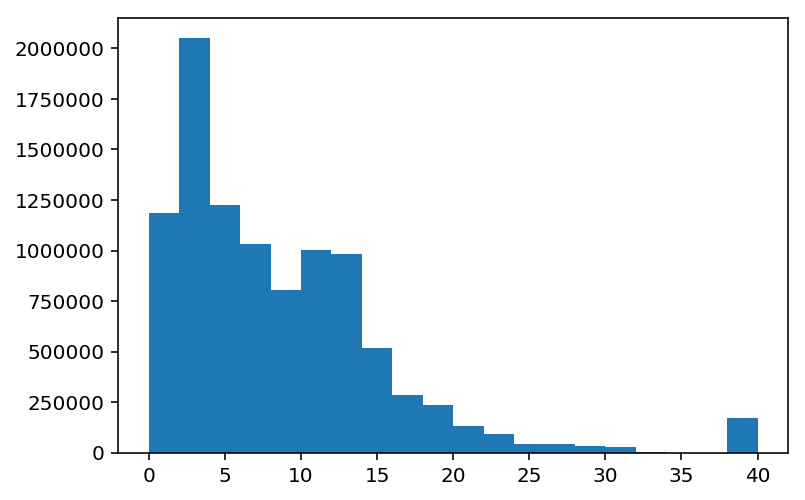

In [30]:
plt.hist(sheddable.age, weights=sheddable.WTHHFIN, bins=20)

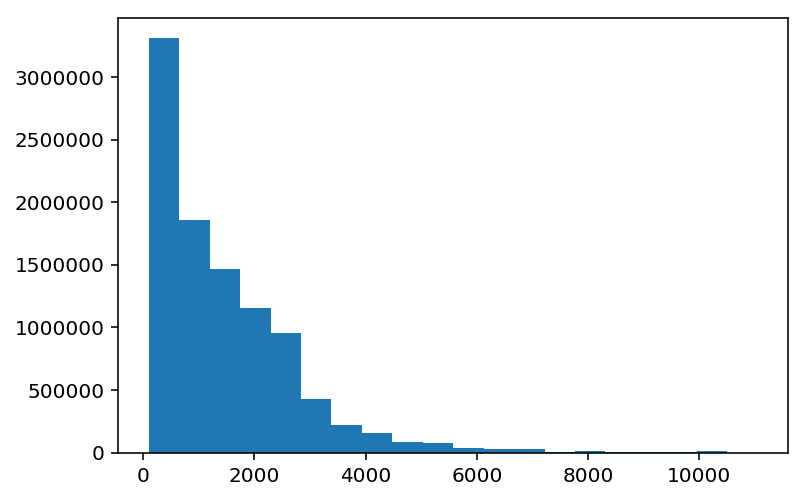

In [67]:
plt.hist(sheddable.BESTMILE, weights=sheddable.WTHHFIN, bins=20)
histToCsv(sheddable.BESTMILE, weights=sheddable.WTHHFIN, bins=20, outputFile='../summary_output/annual_mileage_of_vehicles_with_average_cost_greater_than_1_50_per_mile_hist.csv')

In [33]:
np.sum(sheddable.WTHHFIN[sheddable.BESTMILE < 2000]) / np.sum(sheddable.WTHHFIN)

0.7301763890944121